In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from transformers import AutoTokenizer, AutoModel
import torch
import sqlite3
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS
import pandas as pd

In [2]:
# Подключение к базе данных
conn = sqlite3.connect('../db/normalized_data.db')
cursor = conn.cursor()

# Извлечение данных из столбца job_name_norm
cursor.execute("SELECT job_name_norm FROM jobs")
rows = cursor.fetchall()
sentences = [row[0] for row in rows]

# Закрытие соединения с базой данных
conn.close()

In [3]:
# Загрузка модели BERT
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru")
model = AutoModel.from_pretrained("ai-forever/sbert_large_nlu_ru")

# Токенизация предложений
encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=24, return_tensors='pt')

# Вычисление токенов
with torch.no_grad():
    model_output = model(**encoded_input)

In [5]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [6]:
# Проведение кластеризации методом к-ближайших соседей
vectorizer = TfidfVectorizer()
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
X = sentence_embeddings.numpy()

In [30]:
optics = OPTICS(min_samples=3)
optics.fit(X)

C:\Users\alexx\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_optics.py:992: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


OPTICS(min_samples=3)

In [31]:
clusters = optics.labels_

# Определение количества уникальных кластеров (за исключением шумовых точек)
unique_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print(f'Количество определенных кластеров: {unique_clusters}')

Количество определенных кластеров: 278


In [32]:
clusters

array([  0,   0, 119, ..., 186,  -1,  -1])

In [48]:
kmeans = KMeans(n_clusters=100, random_state=42)
kmeans.fit(X)

C:\Users\alexx\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=100, random_state=42)

In [ ]:
cluster_labels = kmeans.predict(X)

In [149]:
dbscan = DBSCAN(eps=0.5, min_samples=2)

cluster_labels = dbscan.fit_predict(X)
print(cluster_labels)
# clusters - это массив меток кластеров, полученный от DBSCAN
unique_clusters = np.unique(cluster_labels)

# Подсчет количества уникальных кластеров, исключая шум (метка -1)
n_clusters = len(unique_clusters) - (1 if -1 in clusters else 0)

print(f'Количество уникальных кластеров: {n_clusters}')

[ 0  0  1 ... 70 -1 -1]
Количество уникальных кластеров: 376


In [179]:
hierarchical = AgglomerativeClustering(n_clusters=350)
clusters = hierarchical.fit_predict(X)

In [180]:
unique_clusters = clusters

In [181]:
len(np.unique(clusters))

350

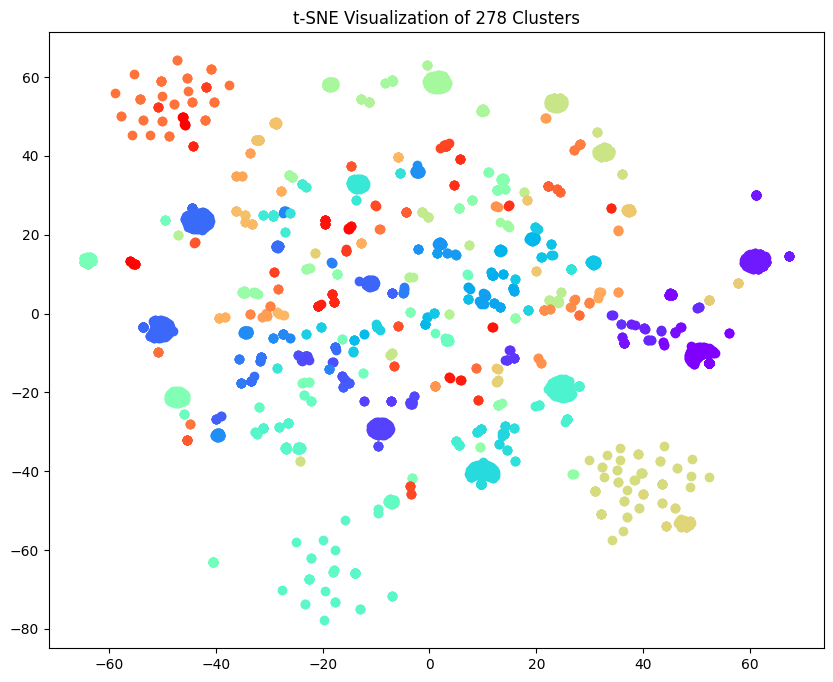

In [34]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import numpy as np

cluster_labels = clusters

# Применение t-SNE для снижения размерности
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Визуализация 50 кластеров
n_clusters = 278
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
labels = cluster_labels  # Убедитесь, что cluster_labels содержит метки для 50 кластеров

plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    plt.scatter(X_tsne[labels == i, 0], X_tsne[labels == i, 1], color=colors[i], label=f'Cluster {i}')

plt.title(f't-SNE Visualization of {n_clusters} Clusters')
plt.show()

In [35]:
df = pd.DataFrame({'Профессия': sentences, 'Кластер': clusters})

In [36]:
df

,Профессия,Кластер
0,ветеринарный врач,0
1,ветеринарный врач,0
2,тракторист-машинист,119
3,тракторист-машинист,119
4,агроном,90
...,...,...
4330,старший инженер,165
4331,зоотехник,186
4332,зоотехник,186
4333,помощник зоотехника по кормлению,-1


In [37]:
# Подключение к базе данных для сохранения сниппета
db_path_norm = "../db//normalized_data.db"
conn_norm = sqlite3.connect(db_path_norm)

df.to_sql(name='clusters', con=conn_norm, if_exists='replace', index=False)

4335